# Imports

In [0]:
import numpy as np
import pandas as pd
from google.colab import drive
import math
import glob
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import time
from sklearn.pipeline import Pipeline

# Function definition

In [0]:
# Import dataset

# Filename (loads only from one file)
filename = 'drive/My Drive/TFG_Info_Data/OwnTraffic/CSVs_etiquetados/second_try_labeled.csv'

# Directory name (loads every csv from directory and merges them)
globDirectory = 'drive/My Drive/TFG_Info_Data/Old/Sample 2/*.csv'

# Loads only one file
def load_one_file(filename):
  drive.mount('drive')
  
  print('Loading ' + filename + '...', end='')
  df = pd.read_csv(filename,
                  sep=',',            # separator
                  header=0,           # row to use as column names
                  index_col=None,     # index
                  low_memory=False)
  print(' Done.')
  return df


# Load every csv and join them
def load_from_dir(globDirectory):
  drive.mount('drive')

  imported_dfs = []

  # First of all, we want to read every CSV and concat them
  for filename in glob.glob(globDirectory):
    print('Loading ' + filename + '...', end='')
    day_df = pd.read_csv(filename,
                  sep=',',            # separator
                  header=0,           # row to use as column names
                  index_col=None,     # index
                  low_memory=False)
    print(' Done.')
    
    imported_dfs.append(day_df)

  df = pd.concat(imported_dfs)

  print('Dataframes merged.')

  return df

# Dataframe loading and preprocessing

In [14]:
df = load_one_file(filename)

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
Loading drive/My Drive/TFG_Info_Data/OwnTraffic/CSVs_etiquetados/second_try_labeled.csv... Done.


In [0]:
# Unnecessary data
df = df.drop(columns=['Dst IP', 'Dst Port', 'Flow Byts/s', 'Flow ID', 'Flow Pkts/s', 'Src IP', 'Src Port', 'Timestamp', 'Protocol'], axis=1)

# NaN columns
df = df.dropna(axis=1)
df = df.loc[:, (df != 0).any(axis=0)]

# Attack = 1 / Benign = 0
df.loc[df.Label != 'Benign', 'Label'] = 1
df.loc[df.Label == 'Benign', 'Label'] = 0

# Training

In [16]:
param_grid = [
    {
      'logistic__C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], # valores para C
    }
]

start_time = time.time()
print("Grid Search...", end='')

# Train and test
Y = df['Label'].to_list()
X = df.drop(['Label'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)

# Pipeline creation
logreg = LogisticRegression(max_iter=20000)
pipe = Pipeline(steps=[('standardscaler', StandardScaler()), ('logistic', logreg)])

gridsearch = GridSearchCV(pipe, param_grid, cv=5, verbose=3)

gridsearch.fit(X_train, np.array(y_train))

ellapsed_time = time.time() - start_time

gridsearch.data_header = df.columns

print("Finished. Ellapsed time: {:d} min {:d} seg".format(int(ellapsed_time/60), int(ellapsed_time) % 60))

Grid Search...Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] logistic__C=0.001 ...............................................
[CV] ................... logistic__C=0.001, score=0.833, total=   0.1s
[CV] logistic__C=0.001 ...............................................
[CV] ................... logistic__C=0.001, score=0.823, total=   0.1s
[CV] logistic__C=0.001 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ................... logistic__C=0.001, score=0.821, total=   0.1s
[CV] logistic__C=0.001 ...............................................
[CV] ................... logistic__C=0.001, score=0.819, total=   0.1s
[CV] logistic__C=0.001 ...............................................
[CV] ................... logistic__C=0.001, score=0.819, total=   0.1s
[CV] logistic__C=0.01 ................................................
[CV] .................... logistic__C=0.01, score=0.853, total=   0.1s
[CV] logistic__C=0.01 ................................................
[CV] .................... logistic__C=0.01, score=0.855, total=   0.1s
[CV] logistic__C=0.01 ................................................
[CV] .................... logistic__C=0.01, score=0.851, total=   0.1s
[CV] logistic__C=0.01 ................................................
[CV] .................... logistic__C=0.01, score=0.847, total=   0.1s
[CV] logistic__C=0.01 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.8min finished


Finished. Ellapsed time: 3 min 11 seg


# Results

## Accuracy

In [17]:
y_pred = gridsearch.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(gridsearch.score(X_test, y_test) * 100))

Accuracy of logistic regression classifier on test set: 88.44


## Confusion Matrix

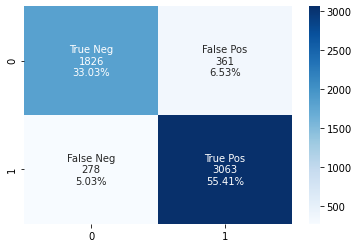

In [18]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

## Report

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Benign', 'Attack']))

              precision    recall  f1-score   support

      Benign       0.87      0.83      0.85      2187
      Attack       0.89      0.92      0.91      3341

    accuracy                           0.88      5528
   macro avg       0.88      0.88      0.88      5528
weighted avg       0.88      0.88      0.88      5528



## ROC Curve

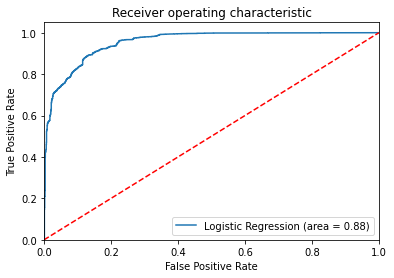

In [21]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 

logit_roc_auc = roc_auc_score(y_test, gridsearch.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gridsearch.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Pickling

In [22]:
import pickle

directory = 'drive/My Drive/TFG_Info_Data/' 

# We need to know which columns are being used for training
gridsearch.data_header = df.columns

with open(directory+'test.pkl','wb+') as f:
  pickle.dump(gridsearch, f)
  print('Model saved.')

Model saved.
